In [2]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import timeit

from colorama import Fore
from sklearn.metrics import auc, roc_curve, precision_score, recall_score

from utils.vocab import Vocabulary
from utils.reader import Data
from utils.utils import print_progress, create_checkpoints_dir

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

Main model parameters:
- *batch_size* - the number of samples in a batch
- *embed_size* - the dimension of embedding space (should be less than vocabulary size)
- *hidden_size* - the number of hidden states in lstm 
- *num_layers* - the number of lstm blocks
- *checkpoints* - path to checkpoint directory
- *std_factor* - the number of stds that is used for defining a model threshold
- *dropout* - the probability that each element is kept
- *vocab* - the Vocabulary object

In [4]:
params = {
    "batch_size": 128,
    "embed_size": 64,
    "hidden_size": 64,
    "num_layers": 2,
    "checkpoints": "./checkpoints/",
    "std_factor": 6.,
    "dropout": 0.7,
}

path_normal_data = "datasets/vulnbank_train.txt"
path_anomaly_data = "datasets/vulnbank_anomaly.txt"

create_checkpoints_dir(params["checkpoints"])

vocab = Vocabulary()
params["vocab"] = vocab

d = Data(path_normal_data)

Downloaded 21991 samples


# Model 

In this part of the code the Sequence-to-Sequence model for determining anomalies is defined.  
The same sequences are fed to the input and output of the model. So the model learns to reconstruct them. At the stage of training and validation, only valid samples are submitted to the model. The validation phase is needed in order to initialize the threshold value.

In [5]:
class Seq2Seq():
    def __init__(self, args):
        tf.reset_default_graph()

        self.batch_size = tf.placeholder(tf.int32, [], name='batch_size')
        self.max_seq_len = tf.placeholder(tf.int32, [], name='max_seq_len')
        self.inputs = tf.placeholder(tf.int32, [None, None], name='inputs')
        self.targets = tf.placeholder(tf.int32, [None, None], name='targets')
        self.lengths = tf.placeholder(tf.int32, [None, ], name='lengths')
        self.dropout = tf.placeholder(tf.float32, name='dropout')
        
        self.num_layers = args['num_layers']
        self.hidden_size = args['hidden_size']
        self.vocab = args['vocab']

        dec_input = self._process_decoder_input(
            self.targets,
            self.vocab.vocab,
            tf.to_int32(self.batch_size))

        vocab_size = len(self.vocab.vocab)

        # Embeddings for inputs
        embed_initializer = tf.random_uniform_initializer(-np.sqrt(3), np.sqrt(3))

        with tf.variable_scope('embedding'):
            embeds = tf.get_variable(
                'embed_matrix',
                [vocab_size, args['embed_size']],
                initializer=embed_initializer,
                dtype=tf.float32)

            enc_embed_input = tf.nn.embedding_lookup(embeds, self.inputs)
            
        enc_state = self._encoder(enc_embed_input)
        
        # Embeddings for outputs
        with tf.variable_scope('embedding', reuse=True):
            dec_embed_input = tf.nn.embedding_lookup(embeds, dec_input)

        dec_outputs = self._decoder(enc_state, dec_embed_input)

        weight, bias = self._weight_and_bias(args['hidden_size'], vocab_size)
        outputs = tf.reshape(dec_outputs[0].rnn_output, [-1, args['hidden_size']])
        logits = tf.matmul(outputs, weight) + bias

        logits = tf.reshape(logits, [-1, self.max_seq_len, vocab_size], name='logits')
        self.probs = tf.nn.softmax(logits, name='probs')
        self.decoder_outputs = tf.argmax(logits, axis=2)

        self.cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits,
            labels=self.targets,
            name='cross_entropy')
        self.batch_loss = tf.identity(tf.reduce_mean(self.cross_entropy, axis=1), name='batch_loss')
        self.loss = tf.reduce_mean(self.cross_entropy)

        self.train_optimizer = self._optimizer(self.loss)

        # Saver
        self.saver = tf.train.Saver()
        
    def _encoder(self, enc_embed_input):
        """
        Adds an encoder to the model architecture.
        """
        cells = [self._lstm_cell(self.hidden_size) for _ in range(self.num_layers)]
        multilstm = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)

        _, enc_state = tf.nn.dynamic_rnn(
            multilstm,
            enc_embed_input,
            sequence_length=self.lengths,
            swap_memory=True,
            dtype=tf.float32)
        
        return enc_state
    
    def _decoder(self, enc_state, dec_embed_input):
        """
        Adds a decoder to the model architecture.
        """
        output_lengths = tf.ones([self.batch_size], tf.int32) * self.max_seq_len
        helper = tf.contrib.seq2seq.TrainingHelper(
            dec_embed_input,
            output_lengths,
            time_major=False)

        cells = [self._lstm_cell(self.hidden_size) for _ in range(self.num_layers)]
        dec_cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)

        decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, helper, enc_state)

        dec_outputs = tf.contrib.seq2seq.dynamic_decode(
            decoder,
            output_time_major=False,
            impute_finished=True,
            maximum_iterations=self.max_seq_len, swap_memory=True)
        
        return dec_outputs
    
    def _optimizer(self, loss,):
        """
        Optimizes weights given a loss. 
        """
        def _learning_rate_decay_fn(learning_rate, global_step):
            return tf.train.exponential_decay(learning_rate, global_step, decay_steps=10000, decay_rate=0.99)

        starting_lr = 0.001
        starting_global_step = tf.Variable(0, trainable=False)
        optimizer = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=starting_global_step,
            learning_rate=starting_lr,
            optimizer=tf.train.AdamOptimizer,
            learning_rate_decay_fn=lambda lr, gs: _learning_rate_decay_fn(lr, gs),
            clip_gradients=5.0)
        
        return optimizer
    
    def _process_decoder_input(self, target_data, char_to_code, batch_size):
        """
        Concatenates the <GO> to the begining of each batch.
        """
        ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
        dec_input = tf.concat([tf.fill([batch_size, 1], char_to_code['<GO>']), ending], 1)

        return dec_input

    def _lstm_cell(self, hidden_size):
        """
        Returns LSTM cell with dropout.
        """
        cell = tf.contrib.rnn.LSTMCell(
            hidden_size,
            initializer=tf.contrib.layers.xavier_initializer())

        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=self.dropout)

        return cell

    def _weight_and_bias(self, in_size, out_size):
        """
        Initializes weights and biases.
        """
        weight = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.01))
        bias = tf.Variable(tf.constant(1., shape=[out_size]))

        return weight, bias


# Train

In [6]:
class Trainer():

    def __init__(self, batch_size, checkpoints_path, dropout):
        self.batch_size = batch_size
        self.checkpoints = checkpoints_path
        self.path_to_graph = checkpoints_path + 'seq2seq'
        self.dropout = dropout

    def train(self, model, train_data, train_size, num_steps, num_epochs, min_loss=0.3):
        """
        Trains a given model architecture with given train data.
        """
        tf.set_random_seed(1234)
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            total_loss = []
            timings = []
            steps_per_epoch = int(train_size / self.batch_size)
            num_epoch = 1
            
            for step in range(1, num_steps):
                beg_t = timeit.default_timer()
                X, L = train_data.next()
                seq_len = np.max(L)

                # For anomaly detection problem we reconstruct input data, so
                # targets and inputs are identical.
                feed_dict = {
                    model.inputs: X,
                    model.targets: X,
                    model.lengths: L,
                    model.dropout: self.dropout,
                    model.batch_size: self.batch_size,
                    model.max_seq_len: seq_len}
                
                fetches = [model.loss, model.decoder_outputs, model.train_optimizer]
                step_loss, _, _ = sess.run(fetches, feed_dict)

                total_loss.append(step_loss)
                timings.append(timeit.default_timer() - beg_t)

                if step % steps_per_epoch == 0:
                    num_epoch += 1

                if step % 200 == 0 or step == 1:
                    print_progress(
                        int(step / 200),
                        num_epoch,
                        np.mean(total_loss),
                        np.mean(step_loss),
                        np.sum(timings))
                    timings = []

                if step == 1:
                    _ = tf.train.export_meta_graph(filename=self.path_to_graph + '.meta')
                
                if np.mean(total_loss) < min_loss or num_epoch > num_epochs:
                    model.saver.save(sess, self.path_to_graph, global_step=step)
                    print("Training is finished.")
                    break


In [7]:
model = Seq2Seq(params)
t = Trainer(params["batch_size"], params["checkpoints"], params["dropout"])

In [8]:
num_steps = 10 ** 6
num_epochs = 60

train_gen = d.train_generator(params["batch_size"], num_epochs)
train_size = d.train_size

t.train(model, train_gen, train_size, num_steps, num_epochs)

Step 0 (epoch 1), average_train_loss = 4.64057, step_loss = 4.64057, time_per_step = 4.530
Step 1 (epoch 2), average_train_loss = 1.85948, step_loss = 1.33259, time_per_step = 806.258
Step 2 (epoch 4), average_train_loss = 1.51688, step_loss = 1.06377, time_per_step = 800.767
Step 3 (epoch 5), average_train_loss = 1.30170, step_loss = 0.76867, time_per_step = 785.980
Step 4 (epoch 7), average_train_loss = 1.12864, step_loss = 0.50699, time_per_step = 784.316
Step 5 (epoch 9), average_train_loss = 0.98843, step_loss = 0.36790, time_per_step = 788.007
Step 6 (epoch 10), average_train_loss = 0.87675, step_loss = 0.29091, time_per_step = 787.017
Step 7 (epoch 12), average_train_loss = 0.78760, step_loss = 0.23059, time_per_step = 786.724
Step 8 (epoch 14), average_train_loss = 0.71524, step_loss = 0.20539, time_per_step = 673.019
Step 9 (epoch 15), average_train_loss = 0.65551, step_loss = 0.16491, time_per_step = 646.233
Step 10 (epoch 17), average_train_loss = 0.60534, step_loss = 0.1555

# Parameters setting

In this part, the threshold setting is introduced. *Set_threshold* calculates the threshold value using *mean* and *std* of loss values of valid samples. 

At the testing stage, the model receives benign and anomalous samples.
For each sample, the value of loss is calculated. If this value is greater than the threshold, then the request is considered anomalous.

If you want to use special checkpoints without training a model, you can import a model from *params["checkpoint"]* .

In [9]:
class Predictor():
    def __init__(self, checkpoints_path, std_factor, vocab):

        self.threshold = 0.
        self.checkpoints = checkpoints_path
        self.path_to_graph = checkpoints_path + 'seq2seq'
        self.std_factor = std_factor
        self.vocab = vocab
        self.__load()

    def __load(self):
        """
        Loads model from the checkpoint directory and sets models params. 
        """
        try:
            loaded_graph = tf.Graph()
            with loaded_graph.as_default():
                saver = tf.train.import_meta_graph(
                    self.path_to_graph + '.meta')

            self.sess = tf.Session(graph=loaded_graph)
            saver.restore(self.sess, tf.train.latest_checkpoint(
                self.checkpoints))

            # loading model parameters
            self.inputs = loaded_graph.get_tensor_by_name('inputs:0')
            self.targets = loaded_graph.get_tensor_by_name('targets:0')
            self.lengths = loaded_graph.get_tensor_by_name('lengths:0')
            self.dropout = loaded_graph.get_tensor_by_name('dropout:0')
            self.batch_size_tensor = loaded_graph.get_tensor_by_name('batch_size:0')
            self.seq_len_tensor = loaded_graph.get_tensor_by_name('max_seq_len:0')
            self.get_batch_loss = loaded_graph.get_tensor_by_name('batch_loss:0')
            self.get_probabilities = loaded_graph.get_tensor_by_name('probs:0')
            self.get_logits = loaded_graph.get_tensor_by_name('logits:0')
            
        except Exception as e:
            raise ValueError('Unable to create model: {}'.format(e))

    def set_threshold(self, data_gen):
        """
        Calculates threshold for anomaly detection.
        """
        
        total_loss = []
        for seq, l in data_gen:
            batch_loss, _ = self._predict_for_request(seq, l)
            total_loss.extend(batch_loss)

        mean = np.mean(total_loss)
        std = np.std(total_loss)
        self.threshold = mean + self.std_factor * std

        print('Validation loss mean: ', mean)
        print('Validation loss std: ', std)
        print('Threshold for anomaly detection: ', self.threshold)
        
        return self.threshold

    def predict(self, data_gen, visual=True):
        """
        Predicts probabilities and loss for given sequences.
        """
        loss = []
        predictions = []
        num_displayed = 0
        
        for seq, l in data_gen:
            batch_loss, alphas = self._predict_for_request(seq, l)
            loss.extend(batch_loss)
            alphas = self._process_alphas(seq, alphas, 1)
            mask = np.array([l > self.threshold for l in batch_loss])
            final_pred = mask.astype(int)
            predictions.extend(final_pred)
            
            if visual and num_displayed < 10 and final_pred == [1]:
                print('\n\nPrediction: ', final_pred[0])
                print('Loss ', batch_loss[0])
                
                num_displayed += 1 
                self._visual(alphas, seq)
        
        return predictions, loss

    def _predict_for_request(self, X, l):
        """
        Predicts probabilities and loss for given data. 
        """
        lengths = [l]
        max_seq_len = l
        feed_dict = {
            self.inputs: X,
            self.targets: X,
            self.lengths: lengths,
            self.dropout: 1.0,
            self.batch_size_tensor: 1,
            self.seq_len_tensor: max_seq_len}

        fetches = [self.get_batch_loss, self.get_probabilities]
        batch_loss, alphas = self.sess.run(fetches, feed_dict=feed_dict)

        return batch_loss, alphas

    def _process_alphas(self, X, alphas, batch_size):
        """
        Counts numbers as probabilities for given data sample.
        """
        processed_alphas = []
        for i in range(batch_size):
            probs = alphas[i]
            coefs = np.array([probs[j][X[i][j]] for j in range(len(X[i]))])
            coefs = coefs / coefs.max()
            processed_alphas.append(coefs)
            
        return processed_alphas

    def _visual(self, alphas, X):
        """
        Colors sequence of malicious characters.
        """
        for i, x in enumerate(X):
            coefs = alphas[i]
            tokens = self.vocab.int_to_string(x)
            
            for j in range(len(x)):
                token = tokens[j]
                if coefs[j] < 0.09:
                    c = Fore.GREEN
                else:
                    c = Fore.BLACK
                if token != '<PAD>' and token != '<EOS>':
                    token = ''.join(c + token)
                    print(token, end='')
                    
            print(Fore.BLACK + '', end='')

In [10]:
p = Predictor(params["checkpoints"], params["std_factor"], params["vocab"])

INFO:tensorflow:Restoring parameters from ./checkpoints/seq2seq-4805


In [11]:
val_gen = d.val_generator()
threshold = p.set_threshold(val_gen)

Validation loss mean:  0.07533215
Validation loss std:  0.108923055
Threshold for anomaly detection:  0.7288704812526703


### Benign samples 

Here FP samples are showed and FP rate is computed.

In [12]:
test_gen = d.test_generator()
valid_preds, valid_loss = p.predict(test_gen)



Prediction:  1
Loss  0.946472
GET /vulnbank/assets/fonts/Pe-icon-7-stroke.woff?d7yf1v HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: http://10.0.212.25/vulnbank/assets/css/pe-icon-7-stroke.css
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged30

Prediction:  1
Loss  0.946472
GET /vulnbank/assets/fonts/Pe-icon-7-stroke.woff?d7yf1v HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: http://10.0.212.25/vulnbank/assets/css/pe-icon-7-stroke.css
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged30

Prediction:  1
Loss  1.1683424
GET /vulnbank/assets/font

Connection: keep-alive

Prediction:  1
Loss  0.946472
GET /vulnbank/assets/fonts/Pe-icon-7-stroke.woff?d7yf1v HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: http://10.0.212.25/vulnbank/assets/css/pe-icon-7-stroke.css
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged30

Prediction:  1
Loss  1.1683424
GET /vulnbank/assets/fonts/glyphicons-halflings-regular.woff2 HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: http://10.0.212.25/vulnbank/assets/css/bootstrap.min.css
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged30

Prediction:  1
Loss  1.1683424

In [13]:
print('Number of FP: ', np.sum(valid_preds))
print('Number of samples: ', len(valid_preds))
print('FP rate: {:.4f}'.format(np.sum(valid_preds) / len(valid_preds)))

Number of FP:  8
Number of samples:  2200
FP rate: 0.0036


### Anomalous samples 

Here TP samples are showed and TP rate is computed.

In [14]:
pred_data = Data(path_anomaly_data, predict=True)
pred_gen = pred_data.predict_generator()
anomaly_preds, anomaly_loss = p.predict(pred_gen)

Downloaded 1097 samples


Prediction:  1
Loss  2.16642
POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:59.0) Gecko/20100101 Firefox/59.0
Accept: application/json, text/javascript, */*; q=0.01
Accept-Language: en-US,en;q=0.5
Accept-Encoding: gzip, deflate
Referer: http://10.0.212.25/vulnbank/online/login.php
Content-Type: application/x-www-form-urlencoded; charset=UTF-8
X-Requested-With: XMLHttpRequest
Content-Length: 209
Cookie: PHPSESSID=mlacs0uiou344i3fa53s7raut6
Connection: keep-alive

type=user&action=create&username=Jack'+and+extractvalue(0x0a,concat(0x0a,(select version())))+and+'1'='1&password=passw0rd&firstname=first&lastname=last&birthdate=30-08-2017&email=eee%40mail.com&phone=747474747&account=DE44404419569750553340&creditcard=4556-9373-3913-6510

Prediction:  1
Loss  2.2834342
POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:59.0) Gecko/20100101 Fire

type=user&action=login&username=none'+union+select+1,2,login,password,5,6,7,NULL,NULL,10,11,12,13,14,15,16,17+from+users+limit+1+--1

Prediction:  1
Loss  0.9289187
POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:59.0) Gecko/20100101 Firefox/59.0
Accept: application/json, text/javascript, */*; q=0.01
Accept-Language: en-US,en;q=0.5
Accept-Encoding: gzip, deflate
Referer: http://10.0.212.25/vulnbank/online/transactions.php
Content-Type: application/x-www-form-urlencoded; charset=UTF-8
X-Requested-With: XMLHttpRequest
Content-Length: 162
Cookie: PHPSESSID=ch1upt4lk9onm6e26lo4lkc893
Connection: keep-alive

type=transaction&action=send&sender=DE00000111112222233333&recipient=DE11111656567474783838&creditcard=1234-6579-3514-6475&amount=2&comment=<svg onload=alert(1)>

Prediction:  1
Loss  8.67965
POST /vulnbank/onlinebank/api.php?xml HTTP/1.1
Host: vulnbank.com
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:52.0) Geck

<?xml version="1.0" encoding="utf-8"?><!DOCTYPE lolz [<!ENTITY lol "lol"><!ELEMENT login (#PCDATA)><!ENTITY lol1 "&lol;&lol;&lol;&lol;&lol;&lol;&lol;&lol;&lol;&lol;"><!ENTITY lol2 "&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;"><!ENTITY lol3 "&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;"><!ENTITY lol4 "&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;"><!ENTITY lol5 "&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;"><!ENTITY lol6 "&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;"><!ENTITY lol7 "&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;"><!ENTITY lol8 "&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;"><!ENTITY lol9 "&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;">]><api><type>user</type><action>forgotpass</action><username>j.doe</username><password>&lol9;</password><code>000</code></api>

Prediction:  1
Loss  2.2545607
POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
Co

type=user&action=infoupdate&firstname=John&lastname=Doe&phone=79035222212&email=j.doe%40vulnbank.de&birthdate=1984-04-04&about=Hi!

Prediction:  1
Loss  2.2545607
POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Content-Length: 130
Accept: application/json, text/javascript, */*; q=0.01
Origin: http://10.0.212.25
X-Requested-With: XMLHttpRequest
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36
Content-Type: application/x-www-form-urlencoded; charset=UTF-8
DNT: 1
Referer: http://10.0.212.25/vulnbank/online/userinfo.php
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9,ru;q=0.8
Cookie: PHPSESSID=7bgg5tald4aea80790it7s1cc1

type=user&action=infoupdate&firstname=John&lastname=Doe&phone=79035222212&email=j.doe%40vulnbank.de&birthdate=1984-04-04&about=Hi!

Prediction:  1
Loss  5.8993344
PUT /cvphqfymlt.txt HTTP/1.1
Host: 10.0.212.25
Content-Length: 10
Connection: close

mb470or8sl


In [15]:
print('Number of TP: ', np.sum(anomaly_preds))
print('Number of samples: ', len(anomaly_preds))
print('TP rate: {:.4f}'.format(np.sum(anomaly_preds) / len(anomaly_preds)))

Number of TP:  1097
Number of samples:  1097
TP rate: 1.0000


# Testing 

To evaluate the results, let's compute metrics of quality: precision, recall, ROC-AUC.

In [16]:
y_true = np.concatenate(([0] * len(valid_preds), [1] * len(anomaly_preds)), axis=0)
preds = np.concatenate((valid_preds, anomaly_preds), axis=0)
loss_pred = np.concatenate((valid_loss, anomaly_loss), axis=0)
assert len(y_true)==len(loss_pred)

In [17]:
precision = precision_score(y_true, preds)
recall = recall_score(y_true, preds)
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.9928
Recall: 1.0000


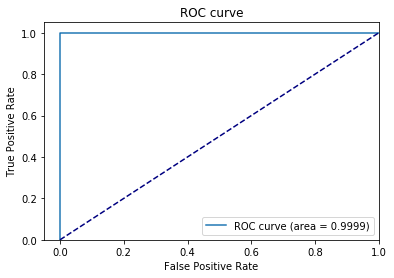

In [18]:
fpr, tpr, _ = roc_curve(y_true, loss_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()